In [25]:
# ==============================================
# LIBRARIES & DIRECTORIES
# ==============================================

import os
import xarray as xr
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt


RAW_DIR = os.path.join("..", "data", "raw")
os.makedirs(RAW_DIR, exist_ok=True)

FLUX_FILE = "sci_xrsf-l2-avg1m_g16_s20170207_e20250416_v2-2-0.nc"
filepath_flux = os.path.join(RAW_DIR, FLUX_FILE)
LABEL_FILE = "sci_xrsf-l2-flsum_g16_s20170209_e20250407_v2-2-0.nc"
filepath_flsum = os.path.join(RAW_DIR, LABEL_FILE)

In [26]:
# ==================================================
# DOWNLOADS FILES FROM NOAA WEBSITE
# ==================================================

FLUX_FILE_URL = (
    "sci_xrsf-l2-avg1m_g16_s20170207_e20250416_v2-2-0.nc",
    "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/"
    "goes/goes16/l2/data/xrsf-l2-avg1m_science/"
    "sci_xrsf-l2-avg1m_g16_s20170207_e20250416_v2-2-0.nc"
)

FLARE_LABEL_FILE_URL = (
    "sci_xrsf-l2-flsum_g16_s20170209_e20250407_v2-2-0.nc",
    "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/"
    "goes/goes16/l2/data/xrsf-l2-flsum_science/"
    "sci_xrsf-l2-flsum_g16_s20170209_e20250407_v2-2-0.nc"
)

def download_if_missing(filename, url, directory):
    path = os.path.join(directory, filename)
    if not os.path.exists(path):
        print(f"Downloading {filename} from NOAA website...")
        response = requests.get(url, stream=True)
        with open(path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    else:
        print(f"{filename} already exists. Skipping download.")
    return path

flux_path = download_if_missing(FLUX_FILE_URL[0], FLUX_FILE_URL[1], RAW_DIR)
flare_path = download_if_missing(FLARE_LABEL_FILE_URL[0], FLARE_LABEL_FILE_URL[1], RAW_DIR)

sci_xrsf-l2-avg1m_g16_s20170207_e20250416_v2-2-0.nc already exists. Skipping download.
sci_xrsf-l2-flsum_g16_s20170209_e20250407_v2-2-0.nc already exists. Skipping download.


In [27]:
# ==================================================
# LOADS AND CLEANS RAW FLUX DATA FROM 2017-2025
# ==================================================

# Loads flux data
print("Loading X-ray flux data file...")
ds_flux = xr.open_dataset(filepath_flux)
df_flux = ds_flux.to_dataframe().reset_index()
print("X-ray flux data file loaded.")

# Drops quad diode files
# Data is captured four rows at a time - only one of every four rows is needed
print(f"Size of dataset (before dropping duplicates): {df_flux.shape}")
df_flux = df_flux.drop_duplicates(subset="time")
df_flux = df_flux[["time", "xrsa_flux", "xrsb_flux"]].sort_values("time").reset_index(drop=True)
print(f"Size of dataset (after dropping duplicates): {df_flux.shape}") # Should be 1/4 of previous size

Loading X-ray flux data file...
X-ray flux data file loaded.
Size of dataset (before dropping duplicates): (17228160, 43)
Size of dataset (after dropping duplicates): (4307040, 3)


In [28]:
# ==================================================
# FINDS AND INTERPOLATES OVER EQUINOX 'ECLIPSE' DROPS
# ==================================================

# Sorts by date/time (dataset may already be sorted)
df_flux["time"] = pd.to_datetime(df_flux["time"])
df_flux = df_flux.sort_values("time").reset_index(drop=True)

# Creates columns for hour/date/month/year 
# for code readability
df_flux["date"] = df_flux["time"].dt.date
df_flux["month"] = df_flux["time"].dt.month
df_flux["hour"] = df_flux["time"].dt.hour
df_flux["year"] = df_flux["time"].dt.year

# Computes a daily median and IQR range
daily_median = df_flux.groupby("date")["xrsb_flux"].transform("median")
daily_q1 = df_flux.groupby("date")["xrsb_flux"].transform(lambda x: x.quantile(0.25))
daily_q3 = df_flux.groupby("date")["xrsb_flux"].transform(lambda x: x.quantile(0.75))
daily_iqr = daily_q3 - daily_q1

# Flags equinox season low-values
# Highly sensitive, and may report some false positives, which is largely fine
df_flux["low_flux_flag"] = (
    (df_flux["month"].isin([2, 3, 4, 8, 9, 10])) & # Values only in months that 'eclipses' occur
    (df_flux["xrsb_flux"] < daily_median - 1.0 * daily_iqr) # Values less than the median - daily IQR
)

# Identifies contiguous blocks
# This is done to ensure that only correctly timed eclipses (which last around 2.5 hours) are actually flagged
df_flux["block_id"] = (df_flux["low_flux_flag"] != df_flux["low_flux_flag"].shift()).cumsum()
block_sizes = df_flux[df_flux["low_flux_flag"]].groupby("block_id").size()
valid_blocks = block_sizes[block_sizes.between(2, 150)].index

# Marks flux value times to be interpolated
# This is an extra step to ensure that only drops between 4-6am (when they occur) are kept
df_flux["flux_is_drop"] = df_flux["block_id"].isin(valid_blocks)
df_flux["flux_is_drop"] &= df_flux["hour"].between(4, 5)  # only keep 4–6 AM windows

# Adds another (arbitrary) condition - post 2021, any flux measurement below 1e-8 is flagged.
date_cutoff = pd.to_datetime("2021-06-01")
df_flux["flux_is_drop"] |= (
    (df_flux["time"] >= date_cutoff) &
    (df_flux["xrsb_flux"] < 1e-8)
)

# Interpolates all values where flux is marked for drop
df_flux["xrsb_flux_clean"] = df_flux["xrsb_flux"].mask(df_flux["flux_is_drop"]).interpolate()
df_flux["xrsb_flux_log"] = np.log10(df_flux["xrsb_flux_clean"])

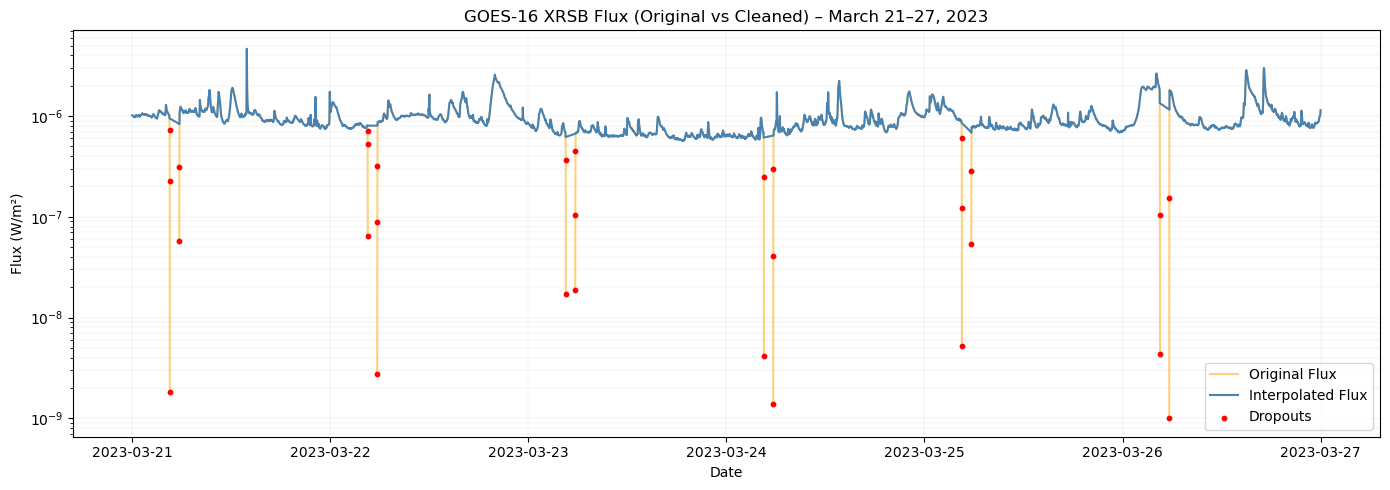

In [29]:
# ==================================================
# VISUALIZATION OF INTERPOLATION FOR 7 DAYS
# ==================================================

# Sets start/end date and gets data only for those days
start_date = pd.to_datetime("2023-03-21")
end_date = pd.to_datetime("2023-03-27")
three_days = (df_flux["time"] >= start_date) & (df_flux["time"] <= end_date)
df_range = df_flux[three_days]

# Plots both unclean flux values and clean flux values, with points for dropouts
plt.figure(figsize=(14, 5))
plt.plot(df_range["time"], df_range["xrsb_flux"], label="Original Flux", color="orange", alpha=0.5) # Original (unclean) flux values
plt.plot(df_range["time"], df_range["xrsb_flux_clean"], label="Interpolated Flux", color="steelblue", linewidth=1.5) # Interpolated (clean) flux values
if "flux_is_drop" in df_range.columns: # Dropouts
    plt.scatter(df_range["time"][df_range["flux_is_drop"]],
                df_range["xrsb_flux"][df_range["flux_is_drop"]],
                color="red", 
                s=10, # size
                label="Dropouts", 
                zorder=5) # puts dots on top of graph
plt.yscale("log")
plt.title("GOES-16 XRSB Flux (Original vs Cleaned) – March 21–27, 2023")
plt.ylabel("Flux (W/m²)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, 
         which="both", # shows major and minor ticks
         lw=0.1) # line weight
plt.tight_layout()
plt.show()

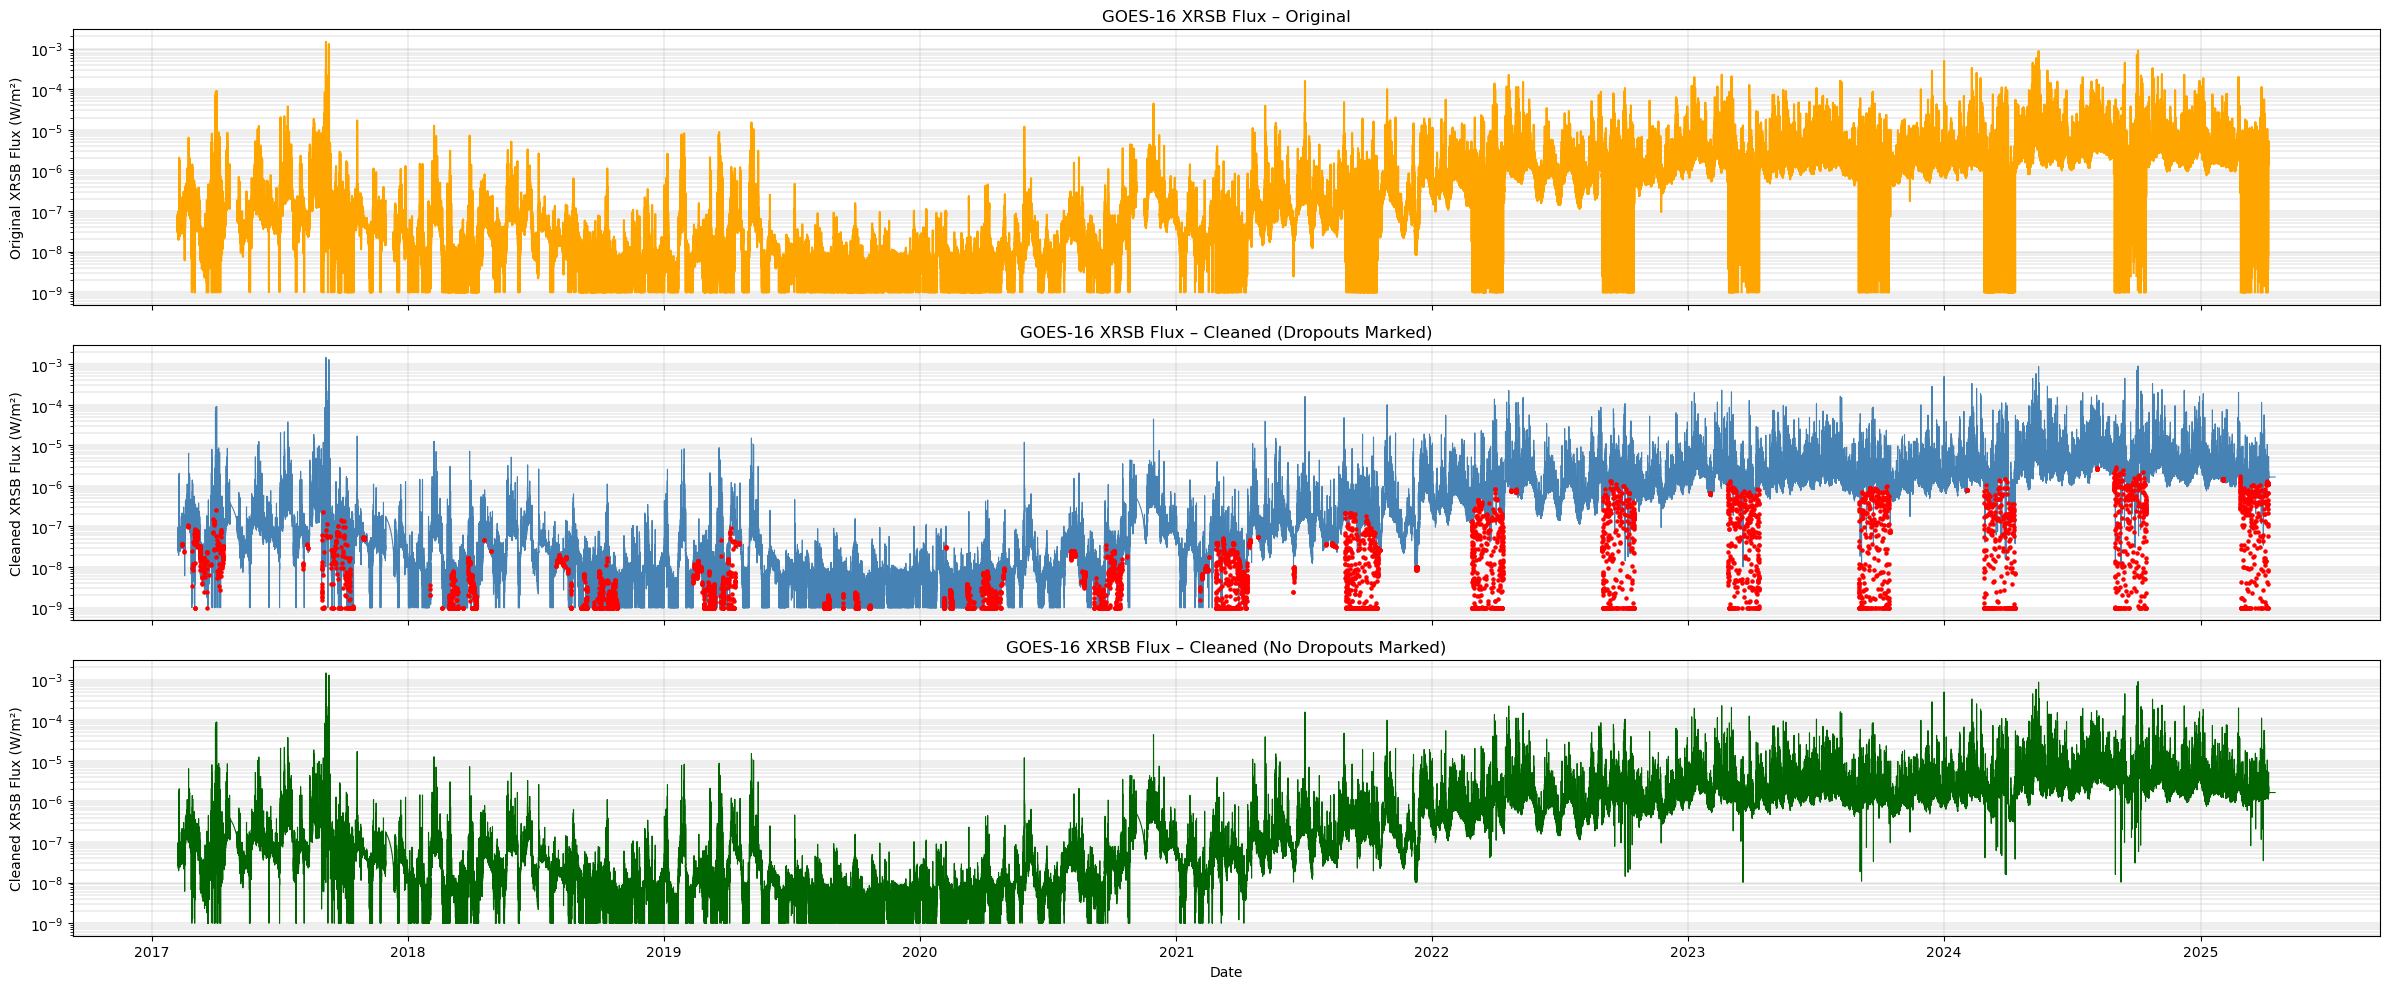

In [30]:
import matplotlib.pyplot as plt

# Makes a multi-axis plot to show all three graphs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 10), sharex=True)

# First panel - original plot
axes[0].plot(df_flux["time"], df_flux["xrsb_flux"], color="orange")
axes[0].set_yscale("log")
axes[0].set_ylabel("Original XRSB Flux (W/m²)")
axes[0].set_title("GOES-16 XRSB Flux – Original")
axes[0].grid(True, which="both", lw=0.3)

# Second panel - cleaned flux with dropout markers
axes[1].plot(df_flux["time"], df_flux["xrsb_flux_clean"], color="steelblue", linewidth=0.8, label="Cleaned Flux")
axes[1].scatter(df_flux["time"][df_flux["flux_is_drop"]],
                df_flux["xrsb_flux"][df_flux["flux_is_drop"]],
                color="red", s=5, label="Interpolated Dropouts", zorder=5)
axes[1].set_yscale("log")
axes[1].set_ylabel("Cleaned XRSB Flux (W/m²)")
axes[1].set_title("GOES-16 XRSB Flux – Cleaned (Dropouts Marked)")
axes[1].grid(True, which="both", lw=0.3)

# Third panel - clean flux without dropout markers
axes[2].plot(df_flux["time"], df_flux["xrsb_flux_clean"], color="darkgreen", linewidth=0.8)
axes[2].set_yscale("log")
axes[2].set_ylabel("Cleaned XRSB Flux (W/m²)")
axes[2].set_xlabel("Date")
axes[2].set_title("GOES-16 XRSB Flux – Cleaned (No Dropouts Marked)")
axes[2].grid(True, which="both", lw=0.3)

# === Final Layout ===
plt.tight_layout()
plt.show()

In [31]:
# ==================================================
# OVERWRITES ORIGINAL FLUX WITH CLEANED FLUX
# ==================================================

df_flux["xrsb_flux"] = df_flux["xrsb_flux_clean"]

# Drops the clean column
df_flux.drop(columns=["xrsb_flux_clean"], inplace=True)

In [32]:
# ==================================================
# LOADS AND CLEANS RAW LABEL DATA FROM 2017-2025
# ==================================================

# Loads the flare summary file
print("Loading flare summary file...")
ds_flsum = xr.open_dataset(filepath_flsum)
df_flares = ds_flsum.to_dataframe().reset_index()
print("Flare summary file loaded.")

print(f"Size of dataset: {df_flares.shape}")

Loading flare summary file...
Flare summary file loaded.
Size of dataset: (50640, 7)


In [ ]:
# ==================================================
# EXTRACTS BINARY, CLASS, & NUMERICAL DATA, 'JOINING' TABLES
# ==================================================

# Extract flare class and magnitude
print("Extracting flare class and magnitude...")
df_flares["class_letter"] = df_flares["flare_class"].str.extract(r"([A-Z])")
df_flares["class_value"] = df_flares["flare_class"].str.extract(r"([0-9]+\.?[0-9]*)").astype(float)
print("Numbering flare classes (B, C, M, X) to (1, 2, 3, 4)")
df_flares["class_num"] = df_flares["class_letter"].map({"B": 1, "C": 2, "M": 3, "X": 4})

# Initalizes label columns in the flux df
df_flux["binary_label"] = 0
df_flux["multiclass_label"] = np.nan
df_flux["regression_target"] = np.nan

# Sets the time column as the index to speed things up
df_flux.set_index("time", inplace=True)

# Loops over the entire flux index, labeling rows in df_flux IF they appear as events in df_flares
print("Matching flare peaks to flux data...")
for _, row in df_flares.iterrows():
    peak_time = row["time"]
    if peak_time in df_flux.index:
        df_flux.at[peak_time, "binary_label"] = 1 # Positive flare
        df_flux.at[peak_time, "multiclass_label"] = row["class_num"] # B/C/M/X flares (as 1-4)
        df_flux.at[peak_time, "regression_target"] = row["class_value"] # Numeric magnitude
print("Done.")

# Resets index back to default from time column
df_flux = df_flux.reset_index()

Extracting flare class and magnitude...

📊 Flare Class Distribution in Dataset:
class_letter
B    3913
C    8364
M    1460
X      73
Name: count, dtype: int64
Numbering flare classes (B, C, M, X) to (1, 2, 3, 4)
Matching flare peaks to flux data...
Done.


In [34]:
# ==================================================
# SAVES NEW LABELED DATASET
# ==================================================
PROCESSED_DIR = os.path.join("..", "data", "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

output_file = os.path.join(PROCESSED_DIR, "flux_with_labels.csv")
df_flux.to_csv(output_file, index=False)
print(f"Saved labeled dataset to {output_file}")

# .head() preview of labeled rows
print("Sample of labeled rows:")
print(df_flux[df_flux["binary_label"] == 1].head())

Saved labeled dataset to ..\data\processed\flux_with_labels.csv
Sample of labeled rows:
                    time     xrsa_flux     xrsb_flux        date  month  hour  \
2921 2017-02-09 00:41:00  2.711966e-08  1.114654e-07  2017-02-09      2     0   
2930 2017-02-09 00:50:00  4.325080e-08  3.800934e-07  2017-02-09      2     0   
2937 2017-02-09 00:57:00  3.119617e-08  2.325111e-07  2017-02-09      2     0   
2953 2017-02-09 01:13:00  2.622410e-08  1.151511e-07  2017-02-09      2     1   
2970 2017-02-09 01:30:00  2.176940e-08  9.893294e-08  2017-02-09      2     1   

      year  low_flux_flag  block_id  flux_is_drop  xrsb_flux_log  \
2921  2017          False         1         False      -6.952860   
2930  2017          False         1         False      -6.420110   
2937  2017          False         1         False      -6.633556   
2953  2017          False         1         False      -6.938732   
2970  2017          False         1         False      -7.004659   

      binary_lab